# 2 Extract Features
Summary:
1. In this script we extract the Lab & mannequin values 
2. We apply a query based approach to parse features from the narrative of the EMR [WIP]

In [1]:
import sys
sys.path.append(r'../src/1_emr_scripts')

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import Preprocessing as func

## #2.1 Get date of first medication
We will use the date of first prescription to look for mannequin

### #2.1.1 Import treatment and consultations tables

In [2]:
import pandas as pd

# import Medicator
df_med = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/1_raw/Medication_REU.csv', sep=';', header=None)
df_med.columns = ['PATNR', 'periodOfUse_valuePeriod_start_date', 'periodOfUse_valuePeriod_end_date', 'usageDuration_valueDuration_value', 'dosageInstruction_text', 'dosageInstruction_additionalInstruction_text', 'dosageInstruction_timing_repeat_frequency', 'dosageInstruction_timing_repeat_period', 'dosageInstruction_route_display', 'dosageInstruction_doseQuantity_value', 'dosageInstruction_doseQuantity_unit_display_original', 'code_text', 'ATC_code', 'ATC_display', 'ATC_display_nl']

# In case the start date is missing fill with the end date
df_med['periodOfUse_valuePeriod_start_date'] = df_med['periodOfUse_valuePeriod_start_date'].fillna(df_med['periodOfUse_valuePeriod_end_date'])

# Get first consult date
df_pat = pd.read_csv(r'../filters/RA_patients_AllNP_11-10-2022.csv', sep=',', index_col=0)

d_pseudo_pat = dict(zip(df_pat.pseudoId, df_pat.patnr))
d_pseudo_date = dict(zip(df_pat.pseudoId, df_pat.date))

### #2.1.2 Acquire date of first prescription
Description: Acquire first date from baseline where a drug is prescriped for each pseudoId 
- The parameter no_drug_window ensures that there is no drug found prior to baseline for same patient (default = 6 months look behind) 

In [ ]:
df_FirstTreat = func.getStartTreatmentDate(df_med, d_pseudo_pat, d_pseudo_date, no_drug_window=6)

df_FirstTreat.head()

### #2.1.3 Export medication information


In [4]:
df_FirstTreat.to_csv('../filters/RA_patients_AllNP_inclTreatmentStart.csv', sep='|',index=False)

## #2.2 Process Mannequin data

Note: If you want to exclude mannequins of Research Nurses you could run the following Notebook: 

additional_files/Mannequin_filter_RNvsMannequin.ipynb

In [5]:
df_mannequin = pd.read_csv(r'../new_data/1_raw/Mannequin_REU.csv', sep=';')
df_mannequin = df_mannequin[((df_mannequin['description'].isna()) | (df_mannequin['description']=='Gewrichtspop'))]
df_mannequin = df_mannequin.rename(columns={'subject_Patient_value' : 'PATNR', 'description' : 'CATEGORIE'})

# Make subset of patients according to prior SVM selection (see notebook #1)
df_selection = pd.read_csv('../filters/RA_patients_AllNP_11-10-2022.csv', index_col=0)
df_selection['patnr'] = df_selection['patnr'].astype(str)
l_pat_select = list(df_selection['patnr'].unique())
df_mannequin = df_mannequin[df_mannequin['PATNR'].isin(l_pat_select)].copy()

# ensure mannequin is after hix initialization
df_mannequin['created'] =df_mannequin['created'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d', errors='ignore'))
df_mannequin = df_mannequin[((pd.DatetimeIndex(df_mannequin['created']) > pd.to_datetime('20110829', format='%Y%m%d', errors='ignore')))]

df_mannequin.to_csv(r'../new_data/1_raw/Clustering_Gewrichtspop.csv', sep='|', index=False)

/home/tdmaarseveen/.conda/envs/ra_clustering2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (3,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### #2.2.1 Establish difference between Physician & RN
Run additional_files/Mannequin_filter_RNvsMannequin.ipynb to distinguish Physician from Research nurse mannequins

### #2.2.2 Import both Physician & Dubious Mannequins


In [ ]:
import pandas as pd 
df_physician_new = pd.read_csv(r'../new_data/2_preprocessing/Gewrichtspop_REU_physician.csv', sep=';')
df_physician_new['created'] = pd.to_datetime(df_physician_new['created'], format='%Y-%m-%d')
df_physician_new['potentialRN'] = 0
#df_physician_new['potentialRN']

df_mannequin = pd.read_csv(r'../new_data/1_raw/Clustering_Gewrichtspop.csv', sep='|')
df_mannequin.columns = ['ID', 'STELLING', 'ANTWOORD', 'YANTWOORD', 'ZANTWOORD', 'subject_Patient_value', 'XANTWOORD', 'DATUM', 'Cs-code', 'CATEGORIE',  'author_Person_value', 'created', 'MUTDAT']
df_mannequin['created'] = pd.to_datetime(df_mannequin['created'], format='%Y-%m-%d')
df_mannequin['potentialRN'] = 1

df_physician_new.columns, df_mannequin.columns

### 2.3 Combine identified physicians with uncertain entries

Enrich data with Mannequin data filled in by RN (we show that there is no data drift in offshoot analysis)

In [ ]:
# Define columns of interest
l_interest = ['subject_Patient_value', 'author_Person_value',
        'created',  'ID', 'STELLING', 'ANTWOORD', 'YANTWOORD',
        'ZANTWOORD', 'XANTWOORD', 'DATUM', 'CATEGORIE', 'potentialRN']

# Create unique keys (to prevent duplications further downstream)
df_mannequin['new_key'] = df_mannequin['subject_Patient_value'].astype(str) + '_' + df_mannequin['DATUM']
df_physician_new['new_key'] = df_physician_new['subject_Patient_value'].astype(str) + '_' + df_physician_new['DATUM']

# Identify rows whereby we are not certain that the mannequin was filled in by a physician
l_pat = list(set(df_mannequin['new_key']) - set(df_physician_new['new_key']))

# Add those extra entries to the Mannequin data (pd.concat)
df_all = pd.concat([df_physician_new[l_interest], df_mannequin[df_mannequin['new_key'].isin(l_pat)][l_interest]], axis=0)

# ToDo: Maybe include lab -> if there is no Lab around the consult data - but there is Lab that can be linked 
# to Mannequin somewhere before the first medication -> than we perhaps want to use the alternative data instead..
# this might result in more patients altogether
# ToDo: Check if this is a dilution? -> sensitivity analysis

print('Length physician mannequin= %s; length dubious (putative RN) mannequin= %s ' % (len(df_physician_new[l_interest]), len( df_mannequin[df_mannequin['new_key'].isin(l_pat)])))
print('Length merged mannequin df: ', len(df_all))

# Export the dubious mannequin data
df_mannequin[df_mannequin['new_key'].isin(l_pat)][l_interest].to_csv(r'../new_data/offshoots/DAS_check/Gewrichtspop_REU_PutativeRN.csv', sep=';', index=None)

# Export enriched dataset
df_all.to_csv(r'../new_data/2_preprocessing/Gewrichtspop_REU_Total.csv', sep=';', index=None)
df_all.head()

## #2.4 Get Mannequin at baseline

- get mannequin at/after baseline and ensure mannequin is registered before medication 
- ensure there is no medication 6 months (or 1 year?) prior to the mannequin 
- no medication at baseline automatically implies that there is also no mannequin at baseline (because we only consider patients that got medication at some point). Because mann  

Mannequin filter : in order to get insight into who performed the physical assesment of patients. You must have first run additional_files/Mannequin_filter_RNvsMannequin.ipynb to distinguish Physician from RN mannequins

In [51]:
import pandas as pd

df_ddra = pd.read_csv(r'../new_data/2_preprocessing/Gewrichtspop_REU_Total.csv', sep=';')
df_ddra.columns = ['PATNR', 'BEHANDELAAR','DATUM_A', 'ID', 'STELLING', 'ANTWOORD', 'YANTWOORD', 'ZANTWOORD', 'XANTWOORD', 'DATUM', 'CATEGORIE', 'potentialRN']


df_treat = pd.read_csv('../new_data/5_clustering/df_metadata_keys.csv', sep=',')
df_ddra = df_ddra[df_ddra['PATNR'].isin(df_treat['patnr'])].copy()
len(df_ddra[df_ddra['STELLING'].isin(['VAS Patient (mm)'])]['PATNR'].unique())

1237

In [8]:
import pandas as pd

MANFILTER = True # Only if you have run the mannequin filter (to differentiate between physicians and RN)

if MANFILTER: 
    df_ddra = pd.read_csv(r'../new_data/2_preprocessing/Gewrichtspop_REU_Total.csv', sep=';')
    df_ddra.columns = ['PATNR', 'BEHANDELAAR','DATUM_A', 'ID', 'STELLING', 'ANTWOORD', 'YANTWOORD', 'ZANTWOORD', 'XANTWOORD', 'DATUM', 'CATEGORIE', 'potentialRN']
else:
    df_ddra = pd.read_csv(r'../new_data/1_raw/Clustering_Gewrichtspop.csv', sep='|')
    df_ddra.columns = ['PATNR', 'BEHANDELAAR','DATUM_A', 'ID', 'STELLING', 'ANTWOORD', 'YANTWOORD', 'ZANTWOORD', 'XANTWOORD', 'DATUM', 'CATEGORIE']
    
df_ddra['DATUM_A']= pd.to_datetime(df_ddra['DATUM_A'], format='%Y-%m-%d')#\

# Get first medication date
df_treat = pd.read_csv('../filters/RA_patients_AllNP_inclTreatmentStart.csv', sep='|')
d_pseudo_pat = dict(zip(df_treat.pseudoId, df_treat.patnr))
d_pseudo_date = dict(zip(df_treat.pseudoId, df_treat.FirstConsult))
treat_pat = dict(zip(df_treat.pseudoId, df_treat.Lookahead_Treatment))
na_pat = dict(zip(df_treat.pseudoId, df_treat.FILTER_RX_NA_BASELINE))
print(len(treat_pat.keys()))


2691


### #2.4.1 Convert entrybased to visitbased
In this step, we aggregate the multiple entries per visit to a single row. In other words, we summarize the baseline information in 1 row. 

In [ ]:
## import pandas as pd
import numpy as np
l_pat_missingMannequin = []
l_pat_missingMannequinBaseline = []
df_treat['firstMannequin'] = np.nan
df_treat['FILTER_MAN_NA'] = True
df_treat['FILTER_MAN_NA_BASELINE'] = True
df_treat['potentialRN'] = 0

# Create mannequin dataframe
df_man = pd.DataFrame()

#for pseudoId in table
for index, row in df_treat.iterrows():
    pid = row['pseudoId']
    pat = row['patnr']
    sub_df = df_ddra[df_ddra['PATNR']==pat].copy() # select pat
    if len(sub_df) > 0:
        df_treat.at[index,'FILTER_MAN_NA']= False
    else : 
        df_treat.at[index,'FILTER_MAN_NA']= True
    
    min_date = row['FirstConsult'] # get date of first consult

    # Convert string to datetime
    min_date = pd.to_datetime(min_date, format='%Y-%m-%d', errors='ignore')
    sub_df['DATUM_A'] = pd.to_datetime(sub_df['DATUM_A'], format='%Y-%m-%d', errors='ignore') # Voorheen DATUM
    sub_df = sub_df.sort_values(by='DATUM_A')

    # define space where we will search for mannequin
    max_date = pd.to_datetime(row['Lookahead_Treatment'], format='%Y-%m-%d', errors='ignore') 
    max_date = max_date + pd.DateOffset(days=1)  # add one day of tolerance 
    min_date = min_date - pd.DateOffset(days=1) # maybe a day earlier or 30 days?

    # Search for mannequin
    sub_df = sub_df[sub_df['DATUM_A'].between(min_date, max_date, inclusive='both')]
    if len(sub_df) > 0:
        df_treat.at[index,'potentialRN'] = 1
        
        if len(sub_df[sub_df['potentialRN']==0]['DATUM_A']) > 0:
            # Take physician mannequin date
            manDat = sub_df[sub_df['potentialRN']==0]['DATUM_A'].iloc[0]
            df_treat.at[index,'potentialRN'] = 0 
            phys = sub_df[sub_df['potentialRN']==0]['BEHANDELAAR'].iloc[0]
        else :
            # Otherwise take RN mannequin date
            manDat = sub_df['DATUM_A'].iloc[0]
            phys = sub_df['BEHANDELAAR'].iloc[0]
        
        df_treat.at[index,'firstMannequin']= manDat
        df_treat.at[index,'Physician']= phys
        df_treat.at[index,'FILTER_MAN_NA_BASELINE']= False

    # Save valid Mannequin Data in dataframe
    sub_df['pseudoId'] = [pid] * len(sub_df)
    df_man = pd.concat([df_man, sub_df], axis=0)

print('N entries:', len(df_man['pseudoId'].unique()), '\tN patients:', len(df_man['PATNR'].unique()))
        
df_man.to_csv(r'../new_data/2_preprocessing/DF_Mannequin_NEW_firstCon.csv', sep='|', index=True)

# Calculate difference in days between first consult (as registered in Encounter) and first reported mannequin
df_treat['deltaMan'] = pd.to_datetime(df_treat['firstMannequin'], format='%Y-%m-%d', errors='ignore').dt.date -pd.to_datetime(df_treat['FirstConsult'], format='%Y-%m-%d', errors='ignore').dt.date

df_treat.to_csv(r'../filters/RA_patients_AllNP_inclTreatment+Mannequin.csv', sep='|', index=True)

df_treat.head()

### #2.4.2 Check patients w/o mannequin at baseline

In [11]:
# 398
l_pat_manna = set(df_treat[((df_treat['FILTER_MAN_NA_BASELINE']) & (~df_treat['FILTER_RX_NA_BASELINE']))]['patnr']) - set(df_treat[df_treat['FILTER_MAN_NA']]['patnr'])
print('Patients without Mannequin at baseline:', len(l_pat_manna))
df_treat[df_treat['patnr'].isin(l_pat_manna)][['FILTER_RX_NA_BASELINE', 'FILTER_MAN_NA_BASELINE', 'FILTER_MAN_NA', 'patnr', 'FirstConsult', 'firstMannequin', 'Lookahead_Treatment', 'Lookbehind_Treatment']].head(5)

Patients without Mannequin at baseline: 225


,FILTER_RX_NA_BASELINE,FILTER_MAN_NA_BASELINE,FILTER_MAN_NA,patnr,FirstConsult,firstMannequin,Lookahead_Treatment,Lookbehind_Treatment
7,False,True,False,304860252,2011-09-08,NaN,2011-09-08,NaN
8,False,False,False,304867071,2011-09-08,2011-09-08 13:06:00,2011-09-08,NaN
9,False,True,False,304867071,2017-03-14,NaN,2017-03-14,2014-09-23
33,False,True,False,304860943,2011-09-23,NaN,2011-10-31,2010-10-20
41,False,False,False,304869656,2011-10-04,2011-12-08 09:31:00,2012-06-18,NaN


### #2.4.3 Visualize difference in days between FirstConsult and FirstMannequin

- FirstConsult: date of the first consult
- FirstMannequin: date of the first mannequin at/after baseline (prior to medication)
- Takeaway message from the figure: Mannequin is registered close to the baseline in this patient selection

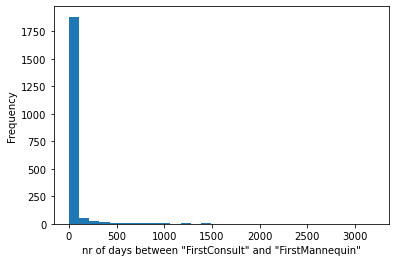

In [12]:
import matplotlib.pyplot as plt
df_treat['deltaMan'] = pd.to_datetime(df_treat['firstMannequin'], format='%Y-%m-%d', errors='ignore').dt.date -pd.to_datetime(df_treat['FirstConsult'], format='%Y-%m-%d', errors='ignore').dt.date
df_treat['deltaMan'] = df_treat['deltaMan'].dt.days
plt.hist(df_treat['deltaMan'], bins=30)
plt.xlabel('nr of days between "FirstConsult" and "FirstMannequin"')
plt.ylabel('Frequency')
plt.show()

(array([1.454e+03, 1.900e+01, 1.500e+01, 2.400e+01, 4.700e+01, 1.400e+01,
        1.600e+01, 5.800e+01, 2.600e+01, 1.400e+01, 1.700e+01, 3.000e+01,
        9.000e+00, 6.000e+00, 9.000e+00, 3.000e+00, 5.000e+00, 3.000e+00,
        1.100e+01, 0.000e+00, 3.000e+00, 1.100e+01, 1.000e+00, 6.000e+00,
        4.000e+00, 5.000e+00, 3.000e+00, 4.000e+00, 7.000e+00, 5.000e+00,
        1.000e+00, 3.000e+00, 6.000e+00, 5.000e+00, 0.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 6.000e+00, 2.000e+00, 3.000e+00,
        6.000e+00, 4.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 3.000e+00]),
 array([-1.,  1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23.,
        25., 27., 29., 31., 33., 35., 37., 39., 41., 43., 45., 47., 49.,
        51., 53., 55., 57., 59., 61., 63., 65., 67., 69., 71., 73., 75.,
        77., 79., 81., 83., 85., 87., 89., 91., 93., 95., 97., 99.]),
 <BarContainer object of 50 artists>)

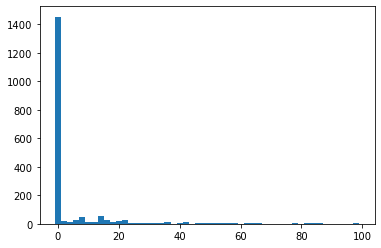

In [13]:
plt.hist(df_treat[df_treat['deltaMan']<100.0]['deltaMan'], bins=50)

#### Unique categories associated with Mannequin components

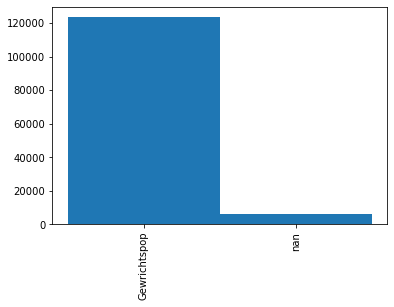

In [14]:
import matplotlib.pyplot as plt
from collections import Counter

labels, values = zip(*Counter(df_man['CATEGORIE']).items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes , labels, rotation=90)
plt.show()

## #2.5 Get Lab values near first Mannequin
#### Lab values of patient selection
For our final selection we require patients to have Mannequin information. We need both mannequin data and the ESR (BSE) to calculate the DAS, thus we look for lab values near the first Mannequin.

#### Tolerance
We accept 1 year of tolerance for serological variables, because these rarely change over time. For other lab features we accept 1 month of tolerance (or time till start treatment if that window is smaller)

In [ ]:
import pandas as pd

# Get last treatment table
df_treat = pd.read_csv(r'../filters/RA_patients_AllNP_inclTreatment+Mannequin.csv', sep='|', index_col=0)

df_lab = pd.read_csv(r'../new_data/1_raw/Lab_REU.csv', sep=';') #new_pat # sep=';',
l_EAC_only = ['Anti nucleaire antistoffen (ANA)', 'ANF', 'Anti-ENA',  'Anti-ENA Kwant.', 'Anti-SS-A', 'Anti-SS-A Kwant.']


# remove autoantibody tests that are only found in EAC
df_lab = df_lab[(~df_lab['code_display_original'].isin(l_EAC_only))]

# select relevant columns 

# BEWARE: issued -> 'effectiveDateTime',
df_lab = df_lab[['issued', 'code_display_original', 'valueQuantity_value', 'valueQuantity_code_original', 'subject_Patient_value', 'valueString']]
df_lab.columns = [ 'Monster_Afname_Datumtijd', 'test_naam_omschrijving', 'uitslag_value', 'uitslag_unit', 'patient_id', 'uitslag_text']


c_date = 'Monster_Afname_Datumtijd' # 'Monster_Afname_Datumtijd'
c_test = 'test_naam_omschrijving' # 'test_naam_omschrijving'
c_pat = 'patient_id' # 'patient_id'


new_df = pd.DataFrame()

# Select relevant patients
df_lab = df_lab[df_lab[c_pat].isin(set(d_pseudo_pat.values()))]

cnt = 0

# Get lab values at baseline!
for index, row in df_treat.iterrows():
    # Serology - ACPA / RF (+/- 1 yr
    pid = row['pseudoId']
    pat = row['patnr']
    
    try : 
        # Serology - ACPA / RF (accept 3 yrs of tolerance)
        l_ser = ['IgM reumafactor', 'Anti-CCP', 'Anti-CCP Kwant.']
        
        sub_df2 = df_lab[((df_lab[c_pat]==pat) & (df_lab[c_test].isin(l_ser)))].copy() # select pat
        ser_min_date = row['firstMannequin'] # get date of first consult
        ser_min_date = pd.to_datetime(ser_min_date, format='%Y-%m-%d', errors='ignore')

        ser_max_date = ser_min_date + pd.DateOffset(years=3) 
        ser_min_date = ser_min_date - pd.DateOffset(years=3)
        sub_df2[c_date] = pd.DatetimeIndex(pd.to_datetime(sub_df2[c_date], format='%Y-%m-%d', errors='ignore'))
        sub_df2 = sub_df2[sub_df2[c_date].between(ser_min_date, ser_max_date, inclusive='both')] # 
        sub_df2['pseudoId'] =  [pid] * len(sub_df2[c_date])
        sub_df2['FirstConsult'] =  [row['firstMannequin']] * len(sub_df2[c_date])
        new_df = pd.concat([new_df, sub_df2])
        
        # Other features (accept one month of tolerance) # before we used to take three months
        sub_df = df_lab[((df_lab[c_pat]==pat) & (~df_lab[c_test].isin(l_ser)))].copy() # select pat
        sub_df['FirstTreat'] =  [row['Lookahead_Treatment']] * len(sub_df[c_date])
        sub_df['FirstPred'] =  [row['Lookahead_Prednison']] * len(sub_df[c_date])
        min_date = row['firstMannequin'] # get date of first consult
        min_date = pd.to_datetime(min_date, format='%Y-%m-%d', errors='ignore')
        
        #max_date = min_date + pd.DateOffset(months=1) # will be dropped later probably
        # Only include up till first treatment or otherwise 1 month
        if len(sub_df) != 0:
            max_date = min([min_date + pd.DateOffset(months=1), pd.to_datetime(sub_df['FirstPred'].iloc[0], format='%Y-%m-%d', errors='ignore')+ pd.DateOffset(days=1)]) 
        else :
            max_date = min_date + pd.DateOffset(months=1) # will probably be dropped later anyway
        # or 1 month prior to first Mannequin
        min_date = min_date - pd.DateOffset(months=1)
        sub_df[c_date] = pd.DatetimeIndex(pd.to_datetime(sub_df[c_date], format='%Y-%m-%d', errors='ignore'))
        sub_df = sub_df[sub_df[c_date].between(min_date, max_date, inclusive='both')]
        sub_df['pseudoId'] =  [pid] * len(sub_df[c_date])
        sub_df['FirstConsult'] =  [row['firstMannequin']] * len(sub_df[c_date])
        
        if len(sub_df) != 0:
            print('%s in Lab dataframe' % pat)
            
        new_df = pd.concat([new_df, sub_df], axis=0)
    except KeyError:
        print(eql)
        continue
    cnt += 1
    if cnt % 100 == 0 :
            print(str(cnt) + 'th iteration')

new_df.to_csv(r'../new_data/2_preprocessing/DF_Lab_firstCon2.csv', sep='|', index=True)
new_df.head()

### #2.4.1 Show unique prescriptions added per day

Text(-0.1, 0.5, 'Number of dossier entries')

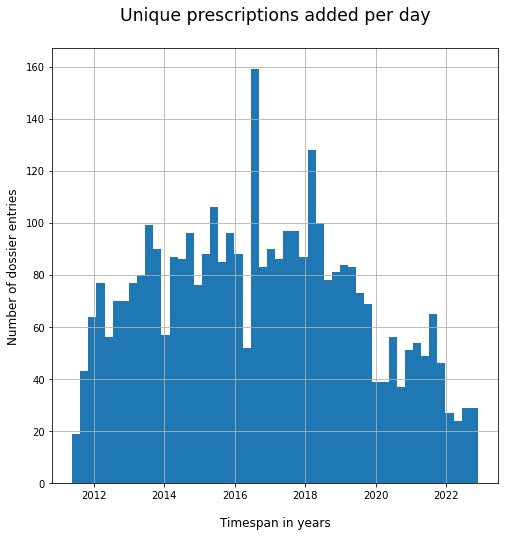

In [17]:
import matplotlib.pyplot as plt 

df_crp = df_lab[df_lab['test_naam_omschrijving']=='IgM reumafactor'].copy() # ['Monster_Afname_Datumtijd'].min()
df_crp = df_crp.reset_index()
plt.rcParams.update({'font.size': 10})
df_crp['Monster_Afname_Datumtijd'] = pd.DatetimeIndex(pd.to_datetime(df_crp['Monster_Afname_Datumtijd'])).tz_localize('UTC')
fig2 = df_crp.groupby(['index'])['Monster_Afname_Datumtijd'].nsmallest(1).hist(bins=50, figsize = (8,8)) 

fig2.set_title('Unique prescriptions added per day', x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig2.text(0.5, -0.1, 'Timespan in years', ha='center', fontsize='large', transform=fig2.transAxes)
fig2.text(-0.1, 0.5, 'Number of dossier entries', va='center', rotation='vertical', fontsize='large', transform=fig2.transAxes)

## #2.5 Get Lab values at baseline to profile the patients w/o mannequin
#### Dropped patients
Some patients do not have a Mannequin, in this case we look from the baseline to elucidate the lab profile of the patients that will be dropped

In [ ]:
import pandas as pd
df_lab = pd.read_csv(r'../new_data/1_raw/Lab_REU.csv', sep=';') #new_pat # sep=';',
l_EAC_only = ['Anti nucleaire antistoffen (ANA)', 'ANF', 'Anti-ENA',  'Anti-ENA Kwant.', 'Anti-SS-A', 'Anti-SS-A Kwant.']

# Import all patient information
df_treat = pd.read_csv(r'../filters/RA_patients_AllNP_inclTreatment+Mannequin.csv', sep='|', index_col=0)

# remove autoantibody tests that are only found in EAC
df_lab = df_lab[(~df_lab['code_display_original'].isin(l_EAC_only))]

# select relevant columns
df_lab = df_lab[['effectiveDateTime', 'code_display_original', 'valueQuantity_value', 'valueQuantity_code_original', 'subject_Patient_value', 'valueString']]
df_lab.columns = ['Monster_Afname_Datumtijd', 'test_naam_omschrijving', 'uitslag_value', 'uitslag_unit', 'patient_id', 'uitslag_text']


c_date = 'Monster_Afname_Datumtijd' # 'Monster_Afname_Datumtijd'
c_test = 'test_naam_omschrijving' # 'test_naam_omschrijving'
c_pat = 'patient_id' # 'patient_id'


new_df = pd.DataFrame()

# Select relevant patients
df_lab = df_lab[df_lab[c_pat].isin(set(d_pseudo_pat.values()))]

# Get lab values at baseline!
cnt = 0
for index, row in df_treat.iterrows():
    # Serology - ACPA / RF (+/- 1 yr
    pid = row['pseudoId']
    pat = row['patnr']
    
    try : 
        # Serology - ACPA / RF (accept 1 yr of tolerance)
        l_ser = ['IgM reumafactor', 'Anti-CCP', 'Anti-CCP Kwant.']
        
        sub_df2 = df_lab[((df_lab[c_pat]==pat) & (df_lab[c_test].isin(l_ser)))].copy() # select pat
        ser_min_date = row['FirstConsult'] # get date of first consult
        ser_min_date = pd.to_datetime(ser_min_date, format='%Y-%m-%d', errors='ignore')

        ser_max_date = ser_min_date + pd.DateOffset(years=3) #pd.Timedelta(3, unit='M') # three months from first consult
        ser_min_date = ser_min_date - pd.DateOffset(years=3)
        sub_df2[c_date] = pd.DatetimeIndex(pd.to_datetime(sub_df2[c_date], format='%Y-%m-%d', errors='ignore'))
        sub_df2 = sub_df2[sub_df2[c_date].between(ser_min_date, ser_max_date, inclusive='both')]
        sub_df2['pseudoId'] =  [pid] * len(sub_df2[c_date])
        sub_df2['FirstConsult'] =  [row['FirstConsult']] * len(sub_df2[c_date])
        sub_df2['FirstTreat'] =  [row['Lookahead_Treatment']] * len(sub_df2[c_date])
        #new_df = new_df.append(sub_df2, ignore_index=True)
        new_df = pd.concat([new_df, sub_df2])
        
        # Other features (accept one month of tolerance) # before we used to take three months
        sub_df = df_lab[((df_lab[c_pat]==pat) & (~df_lab[c_test].isin(l_ser)))].copy() # select pat
        sub_df['FirstTreat'] =  [row['Lookahead_Treatment']] * len(sub_df[c_date])
        sub_df['FirstPred'] =  [row['Lookahead_Prednison']] * len(sub_df[c_date])
        min_date = row['FirstConsult'] # get date of first consult
        min_date = pd.to_datetime(min_date, format='%Y-%m-%d', errors='ignore')
        
        
        # Only include up till first prednison treatment (because of BSE) or otherwise 1 month
        if len(sub_df) != 0:
            max_date = min([min_date + pd.DateOffset(months=1), pd.to_datetime(sub_df['FirstPred'].iloc[0], format='%Y-%m-%d', errors='ignore')+ pd.DateOffset(days=1)]) 
        else :
            max_date = min_date + pd.DateOffset(months=1) # will be dropped later probably
        
        # or 1 month prior to first consult
        min_date = min_date - pd.DateOffset(months=1)
        sub_df[c_date] = pd.DatetimeIndex(pd.to_datetime(sub_df[c_date], format='%Y-%m-%d', errors='ignore'))
        sub_df = sub_df[sub_df[c_date].between(min_date, max_date, inclusive='both')]
        sub_df['pseudoId'] =  [pid] * len(sub_df[c_date])
        sub_df['FirstConsult'] =  [row['FirstConsult']] * len(sub_df[c_date])
        
        if len(sub_df) == 0:
            print('%s not in Lab dataframe' % pat)
        #new_df = new_df.append(sub_df, ignore_index=True)
        new_df = pd.concat([new_df, sub_df], axis=0)
    except KeyError:
        #print('%s not in Lab dataframe' % pat)
        continue
    cnt += 1
    if cnt % 100 == 0 :
            print(str(cnt) + 'th iteration')

new_df.to_csv(r'../new_data/2_preprocessing/DF_Lab_firstCon_PEC.csv', sep='|', index=True)
new_df.head()